In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

bike = pd.read_csv("/Users/apple/Downloads/SupML/Project/Bike-Sharing-Dataset/hour.csv")
bike['Date'] = bike['dteday'].astype(str) + "-" + bike['hr'].astype(str)
bike['Date'] = pd.to_datetime(bike['Date'], format = "%Y-%m-%d-%H")

bike_new = bike.drop(['instant', 'dteday', 'casual', 'registered', 'Date'], axis=1)

In [6]:
def split(X, prop = [0.6,0.2,0.2], shuffle=False):
    df_index = np.arange(X.shape[0])
    if shuffle==True:
        np.random.shuffle(df_index)
    cut1 = int(np.floor(X.shape[0]*prop[0]))
    cut2 = int(np.floor(X.shape[0]*(prop[0]+prop[1])))
    train_index = df_index[:cut1]
    val_index = df_index[cut1:cut2]
    test_index = df_index[cut2:]
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    X_test = X.iloc[test_index]
    return [X_train, X_val, X_test]

In [8]:
bike_train, bike_val, bike_test = split(bike_new, [0.6,0.2,0.2])

bike_train_X = np.array(bike_train.drop(['cnt'], axis=1))
bike_train_Y = np.array(bike_train.loc[:,'cnt'])
bike_train_Y.shape = (bike_train_Y.shape[0], 1)

bike_val_X = np.array(bike_val.drop(['cnt'], axis=1))
bike_val_Y = np.array(bike_val.loc[:,'cnt'])
bike_val_Y.shape = (bike_val_Y.shape[0], 1)

bike_test_X = np.array(bike_test.drop(['cnt'], axis=1))
bike_test_Y = np.array(bike_test.loc[:,'cnt'])
bike_test_Y.shape = (bike_test_Y.shape[0], 1)


In [25]:
learning_rate = 0.0015
training_epochs = 10
batch_size = 10
beta = 1

X = tf.placeholder(tf.float32, [None, 12], name="X")
Y = tf.placeholder(tf.float32, [None, 1], name="Y")

total_len = bike_train_X.shape[0]
n_input = bike_train_X.shape[1]
n_hidden_1 = 10
n_hidden_2 = 20
n_hidden_3 = 25
n_hidden_4 = 20
n_output = 1
    
weights = {
    'w1': tf.Variable(tf.random_normal([n_input, n_hidden_1], 0, 0.001)),
    'w2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], 0, 0.001)),
    'w3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3], 0, 0.001)),
    'w4': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4], 0, 0.001)),
    'w_out': tf.Variable(tf.random_normal([n_hidden_4, n_output], 0, 0.001))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1], 0, 0.001)),
    'b2': tf.Variable(tf.random_normal([n_hidden_2], 0, 0.001)),
    'b3': tf.Variable(tf.random_normal([n_hidden_3], 0, 0.001)),
    'b4': tf.Variable(tf.random_normal([n_hidden_4], 0, 0.001)),
    'b_out': tf.Variable(tf.random_normal([n_output], 0, 0.001))
}

def deep_nn(X, weights, biases):
    
    layer_1 = tf.add(tf.matmul(X, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)

    layer_3 = tf.add(tf.matmul(layer_2, weights['w3']), biases['b3'])
    layer_3 = tf.nn.relu(layer_3)

    layer_4 = tf.add(tf.matmul(layer_3, weights['w4']), biases['b4'])
    layer_4 = tf.nn.relu(layer_4)

    out_layer = tf.matmul(layer_4, weights['w_out']) + biases['b_out']
    return out_layer

pred = deep_nn(X, weights, biases)


reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
cost = tf.sqrt(tf.reduce_mean(tf.square(pred-Y))) + beta * sum(reg_losses)
true_cost = tf.sqrt(tf.reduce_mean(tf.square(pred-Y)))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # Training cycle
    print("training:")
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(total_len/batch_size)
        # Loop over all batches
        for i in range(total_batch-1):
            batch_x = bike_train_X[i*batch_size:(i+1)*batch_size]
            batch_y = bike_train_Y[i*batch_size:(i+1)*batch_size]
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c, p = sess.run([optimizer, cost, pred], feed_dict={X: batch_x,
                                                          Y: batch_y})
            # Compute average loss
            avg_cost += c / total_batch
        if epoch % 10 == 0:
            print(avg_cost)
    
    _, c, train_pred = sess.run([optimizer, true_cost, pred], feed_dict={X: bike_train_X,
                                                          Y: bike_train_Y})
    print("Training set:", c)
    
    _, c, val_pred = sess.run([optimizer, true_cost, pred], feed_dict={X: bike_val_X,
                                                          Y: bike_val_Y})
    print("Validation error:", c)
    
    _, c, test_pred = sess.run([optimizer, true_cost, pred], feed_dict={X: bike_test_X,
                                                          Y: bike_test_Y})
    
    # print("Test error:", c)



training:
174.230899494
Training set: 132.687
Validation error: 251.627


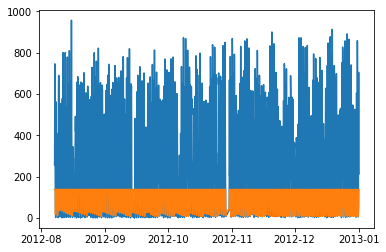

In [26]:
plt.plot(bike.loc[bike_test.index,"Date"], bike_val_Y)
plt.plot(bike.loc[bike_test.index,"Date"], val_pred)
plt.show()